1. Name 3 models of fairness, explain them 
briefly. When should which models be used?  

- Demographic Parity: We are conscious of historical biases of our data
We have a plan in place to support the unprivileged group and to prevent the
reinforcement of historical biases
- Equal Opportunity: Introducing False Positives are not costly to the user nor the company 
The target variable is not considered subjective
- Equalised Odds: The target variable is not considered subjective
There remains a profit for the company


In [28]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

3. Read data creditworthiness.csv
Define ‚IS_DEFAULT‘ as target
Split the data into training and test data
Bias Mitigation

In [29]:
data = pd.read_csv(filepath_or_buffer="./creditworthiness.csv")
# data = data[data["_TREATMENT"] >= 1] # removing control group and not part of experiment

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                30000 non-null  int64  
 1   CC_LIMIT_CAT      30000 non-null  int64  
 2   EDUCATION         30000 non-null  int64  
 3   MARITAL_STATUS    30000 non-null  int64  
 4   GENDER            30000 non-null  int64  
 5   AGE_GROUP         30000 non-null  int64  
 6   pay_status_1      30000 non-null  int64  
 7   pay_status_2      30000 non-null  int64  
 8   pay_status_3      30000 non-null  int64  
 9   pay_status_4      30000 non-null  int64  
 10  pay_status_5      30000 non-null  int64  
 11  pay_status_6      30000 non-null  int64  
 12  paid_pct_1        30000 non-null  float64
 13  paid_pct_2        30000 non-null  float64
 14  paid_pct_3        30000 non-null  float64
 15  paid_pct_4        30000 non-null  float64
 16  paid_pct_5        30000 non-null  float6

In [31]:
from sklearn.model_selection import train_test_split

y = data["IS_DEFAULT"]
X = data.drop(["ID", "IS_DEFAULT"], axis=1)
rand = 9
np.random.seed(rand)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

4. How many women and how many men repay 
the loan late?  
Plot the confusion matrix

In [32]:
data[data["IS_DEFAULT"]==1].GENDER.value_counts()# 1 is male, 2 is female

GENDER
2    3763
1    2873
Name: count, dtype: int64

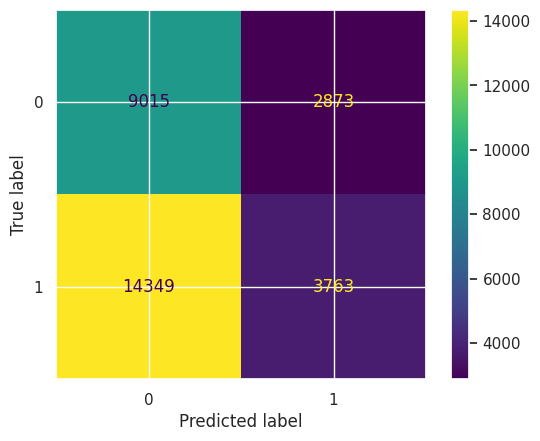

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cfm = confusion_matrix(data.GENDER==2,data["IS_DEFAULT"])
ConfusionMatrixDisplay(cfm).plot()

5. Define as proteced group ‚GENDER‘
6. Define privileged and unprivileged groups

In [34]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

train_ds = BinaryLabelDataset(
    df=data.loc[X_train.index.values].drop(["ID"], axis=1),
    label_names=["IS_DEFAULT"],
    protected_attribute_names=["AGE_GROUP", "GENDER"],
    favorable_label=0,
    unfavorable_label=1,
)
test_ds = BinaryLabelDataset(
    df=data.loc[X_test.index.values].drop(["ID"], axis=1),
    label_names=["IS_DEFAULT"],
    protected_attribute_names=["AGE_GROUP", "GENDER"],
    favorable_label=0,
    unfavorable_label=1,
)
unprivileged_groups=[{'GENDER': 2}]
privileged_groups=[{'GENDER': 1}]
metrics_train_ds = BinaryLabelDatasetMetric(train_ds,\
unprivileged_groups=unprivileged_groups,\
privileged_groups=privileged_groups)
metrics_test_ds = BinaryLabelDatasetMetric(test_ds,\
unprivileged_groups=unprivileged_groups,\
privileged_groups=privileged_groups)

In [35]:
print(
    "Difference in mean outcomes TEST between unprivileged and privileged groups = ",
    metrics_test_ds.mean_difference(),
)
print(
    "Statistical Parity Difference (SPD):\t\t\t%.4f"
    % metrics_train_ds.statistical_parity_difference()
)
print("Disparate Impact (DI):\t\t\t\t\t%.4f" % metrics_train_ds.disparate_impact())
print(
    "Smoothed Empirical Differential Fairness (SEDF):\t%.4f"
    % metrics_train_ds.smoothed_empirical_differential_fairness()
)

Difference in mean outcomes TEST between unprivileged and privileged groups =  0.04012115333925115
Statistical Parity Difference (SPD):			0.0340
Disparate Impact (DI):					1.0451
Smoothed Empirical Differential Fairness (SEDF):	0.3314


In [36]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
from catboost import CatBoostClassifier

rand = 9
np.random.seed(rand)
tf.random.set_seed(rand)
orig_plt_params = plt.rcParams
sns.set()
cb_mdl = CatBoostClassifier(iterations=500, learning_rate=0.5, depth=8)
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False)
y_test_cb_pred = fitted_cb_mdl.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_test_cb_pred)
acc = accuracy_score(y_test,y_test_cb_pred)


CatBoostClassifier without bias mitigation

accuracy =  0.8043333333333333


<Figure size 640x480 with 0 Axes>

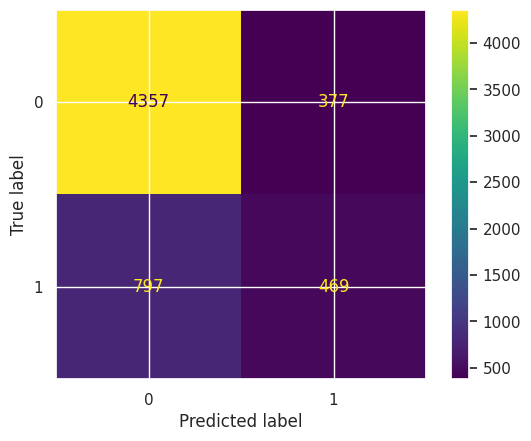

In [37]:
plt.figure()
print("CatBoostClassifier without bias mitigation\n")
print("accuracy = ", acc)
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [38]:
test_pred_ds = test_ds.copy(deepcopy=True)
cb_mdl = CatBoostClassifier(
    iterations=500, learning_rate=0.5, depth=8, class_weights=[0.9, 0.1]
)
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False)
y_test_cb_pred = fitted_cb_mdl.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_test_cb_pred)
acc = accuracy_score(y_test,y_test_cb_pred)


POSW CatBoostClassifier

accuracy =  0.814


<Figure size 640x480 with 0 Axes>

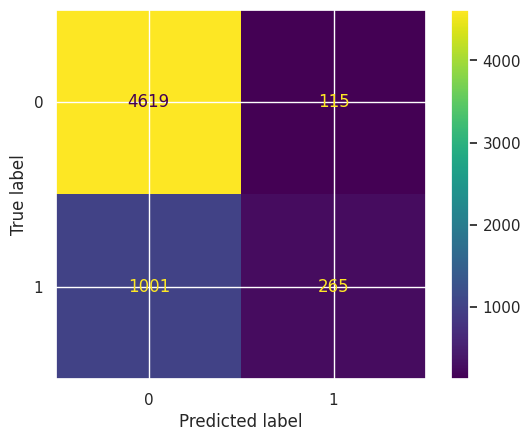

In [39]:
plt.figure()
print("POSW CatBoostClassifier\n")
print("accuracy = ", acc)
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [40]:
from aif360.algorithms.preprocessing import Reweighing

reweigher = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)
reweigher.fit(train_ds)
train_rw_ds = reweigher.transform(train_ds)

In [41]:
train_rw_ds

               instance weights     features                            
                                                                        
                                CC_LIMIT_CAT EDUCATION MARITAL_STATUS   
instance names                                                          
0                      1.059913          0.0       2.0            2.0  \
1                      1.059913          3.0       2.0            1.0   
2                      0.983968          2.0       2.0            1.0   
3                      0.983968          1.0       2.0            2.0   
4                      1.028315          1.0       2.0            2.0   
...                         ...          ...       ...            ...   
23995                  1.028315          2.0       2.0            2.0   
23996                  1.028315          0.0       2.0            2.0   
23997                  1.028315          0.0       2.0            1.0   
23998                  1.028315          0.0       

In [42]:
metrics_train_rw_ds = BinaryLabelDatasetMetric(
    train_rw_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "Reweigher (REW) Statistical Parity Difference (SPD):\t\t\t%.4f"
    % metrics_train_rw_ds.statistical_parity_difference()
)
print(
    "REW Disparate Impact (DI):\t\t\t\t\t%.4f" % metrics_train_rw_ds.disparate_impact()
)
print(
    "REW Smoothed Empirical Differential Fairness (SEDF):\t%.4f"
    % metrics_train_rw_ds.smoothed_empirical_differential_fairness()
)


Reweigher (REW) Statistical Parity Difference (SPD):			0.0000
REW Disparate Impact (DI):					1.0000
REW Smoothed Empirical Differential Fairness (SEDF):	0.2423


reweighted CatBoostClassifier

accuracy =  0.8053333333333333


<Figure size 640x480 with 0 Axes>

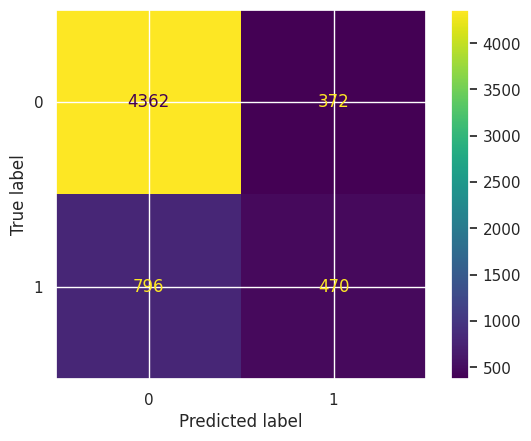

In [43]:
cb_mdl = CatBoostClassifier(iterations=500, learning_rate=0.5, depth=8)
fitted_cb_mdl = cb_mdl.fit(
    X_train, y_train, verbose=False, sample_weight=train_rw_ds.instance_weights
)
y_test_cb_pred = fitted_cb_mdl.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_test_cb_pred)
acc = accuracy_score(y_test,y_test_cb_pred)
plt.figure()
print("reweighted CatBoostClassifier\n")
print("accuracy = ", acc)
ConfusionMatrixDisplay(cf_matrix).plot()
plt.show()

In [45]:
from aif360.algorithms.inprocessing import PrejudiceRemover

log_pr_mdl = PrejudiceRemover(
    eta=1.0, sensitive_attr="AGE_GROUP", class_attr="IS_DEFAULT"
)
log_pr_mdl.fit(train_ds)
train_pred_pr_ds = log_pr_mdl.predict(train_ds)
test_pred_pr_ds = log_pr_mdl.predict(test_ds)

Traceback (most recent call last):
  File "/home/eon/miniconda3/envs/bio/lib/python3.8/site-packages/aif360/algorithms/inprocessing/kamfadm-2012ecmlpkdd/train_pr.py", line 319, in <module>
    main(opt)
  File "/home/eon/miniconda3/envs/bio/lib/python3.8/site-packages/aif360/algorithms/inprocessing/kamfadm-2012ecmlpkdd/train_pr.py", line 166, in main
    clr = train(X, y, ns, opt)
  File "/home/eon/miniconda3/envs/bio/lib/python3.8/site-packages/aif360/algorithms/inprocessing/kamfadm-2012ecmlpkdd/train_pr.py", line 128, in train
    clr.fit(X, y, ns, itype=opt.itype)
  File "/home/eon/miniconda3/envs/bio/lib/python3.8/site-packages/aif360/algorithms/inprocessing/kamfadm-2012ecmlpkdd/fadm/lr/pr.py", line 279, in fit
    self.c_s_ = np.array([np.sum(s == si).astype(np.float)
  File "/home/eon/miniconda3/envs/bio/lib/python3.8/site-packages/aif360/algorithms/inprocessing/kamfadm-2012ecmlpkdd/fadm/lr/pr.py", line 279, in <listcomp>
    self.c_s_ = np.array([np.sum(s == si).astype(np.float)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [46]:
from catboost import CatBoostClassifier
from aif360.algorithms.postprocessing import EqOddsPostprocessing

cb_mdl = CatBoostClassifier(iterations=500, learning_rate=0.5, depth=8)
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False)
y_test_cb_pred = fitted_cb_mdl.predict(X_test)
test_ds = BinaryLabelDataset(
    df=X_test.join(y_test),
    label_names=["IS_DEFAULT"],
    protected_attribute_names=["AGE_GROUP", "GENDER"],
    favorable_label=0,
    unfavorable_label=1,
)
X_posw = X_test.copy()
X_posw["IS_DEFAULT"] = y_test_cb_pred
y_test_cb_pred = BinaryLabelDataset(
    df=X_posw,
    label_names=["IS_DEFAULT"],
    protected_attribute_names=["AGE_GROUP", "GENDER"],
    favorable_label=0,
    unfavorable_label=1,
)
epp = EqOddsPostprocessing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    seed=rand,
)
epp = epp.fit(test_ds, y_test_cb_pred)
test_pred_epp_ds = epp.predict(y_test_cb_pred)
metrics_test_dir_ds = BinaryLabelDatasetMetric(
    test_pred_epp_ds,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)
print(
    "EPP Statistical Parity Difference (SPD):\t\t\t%.4f"
    % metrics_test_dir_ds.statistical_parity_difference()
)
print(
    "EPP Disparate Impact (DI):\t\t\t\t\t%.4f" % metrics_test_dir_ds.disparate_impact()
)
print(
    "EPP Smoothed Empirical Differential Fairness (SEDF):\t%.4f"
    % metrics_test_dir_ds.smoothed_empirical_differential_fairness()
)
print(
    "EPP Difference in mean outcomes TEST between unprivileged and privileged groups in percent",
    round(metrics_test_dir_ds.mean_difference() * 100, 2),
)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and